0. Import packages.

1. output csv names

2. Get USGS site info and data.

1-1 FIX 13310800 2015

2. Get PRISM data and calculate days_since_october_first and rad_d

3. Merge PRISM and USGS data and check NA

4. Get water year

5. base model and Grid Search CV parameters.

6. evaluation function.

7-0 CREATE AN EMPTY DF

7. create dfs and random forest for each site

8. BIAS PER QUARTILE

9. RM SITE = 0 IN THE DF

10. merge filtered_df (USGS site info and data) AND evaluate_df


12. merge sorted_df and var

In [1]:
#%load_ext cudf.pandas

0. Import packages. Set modeling periods, months,locations and idv of the data


In [2]:
!pip install dataretrieval
from dataretrieval import nwis
import pandas as pd
import numpy as np
!pip install statsmodels
from statsmodels.tsa.stattools import acf

#!pip uninstall scikit-learn -y
#!pip install scikit-learn
import sklearn
# Print the version of scikit-learn
print(sklearn.__version__)

from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
#from sklearn.inspection import permutation_importance
from datetime import datetime
current_time = datetime.now()
print(current_time.strftime("%Y-%m-%d %H:%M:%S"))

startDate   =  "1995-10-01"
endDate     =  "2024-09-30"
model_months=  [6 ,7,8]
model_site  = ["12305000","12322000"
              ,"13092747","13150430","13154500","13176400","13190500","13192200","13211205","13213000","13296000","13304050","13307000","13310800","13310850","13311000","13311250","13311450","13317660","13337095","13340000","13340600","13341050","13342500"
              ]
idv         = [ "00060_Mean" ,"tmean" ,"Days_Since_October_1st" ]

1.6.1
2025-06-15 00:47:07


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


1. output csv names

In [4]:
df_cleaned_csv = "df_cleaned.csv"
model_df_site_csv ="model_df_site.csv"
#sort_df is the results after grid search
sorted_df_csv= "sorted_df.csv"
sorted_df_var_csv = '/content/drive/My Drive/LSTM_results/' +"sorted_df_var_" +   current_time.strftime("%Y%m%d%H%M") + ".csv"
site_pred_test_csv= '/content/drive/My Drive/LSTM_results/' +"site_pred_test_" +   current_time.strftime("%Y%m%d%H%M") + ".csv"

1. Get USGS site info and data

In [5]:
site_info = nwis.get_info(sites= model_site )
site_info_df = pd.DataFrame( site_info[0] )
site_info_df["site_no"]=site_info_df["site_no"].astype(str)
columns_to_save = ['site_no', 'dec_lat_va', 'dec_long_va', 'drain_area_va'
                   ,   'alt_va'
                  ]
filtered_df = site_info_df[columns_to_save]
#print(filtered_df)

parameterCode = ["00010","00060"  ]
dailyStreamtemp = nwis.get_dv(sites= model_site
                              , parameterCd=parameterCode, start=startDate, end=endDate)
dailyStreamtemp_df = pd.DataFrame( dailyStreamtemp[0] )
dailyStreamtemp_df = dailyStreamtemp_df.reset_index()
dailyStreamtemp_df['Date'] = dailyStreamtemp_df['datetime'].dt.date
dailyStreamtemp_df['Month'] = dailyStreamtemp_df['datetime'].dt.month
dailyStreamtemp_df['Year'] = dailyStreamtemp_df['datetime'].dt.year
dailyStreamtemp_df = dailyStreamtemp_df[ dailyStreamtemp_df['Month'].isin( model_months  )    ]
print( dailyStreamtemp_df.head() )

      site_no                  datetime  00010_Maximum 00010_Maximum_cd  \
244  12305000 1996-06-01 00:00:00+00:00            NaN              NaN   
245  12305000 1996-06-02 00:00:00+00:00            NaN              NaN   
246  12305000 1996-06-03 00:00:00+00:00            NaN              NaN   
247  12305000 1996-06-04 00:00:00+00:00            NaN              NaN   
248  12305000 1996-06-05 00:00:00+00:00            NaN              NaN   

     00010_Minimum 00010_Minimum_cd  00010_Mean 00010_Mean_cd  00060_Mean  \
244            NaN              NaN         NaN           NaN     39200.0   
245            NaN              NaN         NaN           NaN     39400.0   
246            NaN              NaN         NaN           NaN     41300.0   
247            NaN              NaN         NaN           NaN     44400.0   
248            NaN              NaN         NaN           NaN     42700.0   

    00060_Mean_cd  ...  00010_2_Mean_cd 00010_temperature ysi_Maximum  \
244          

2. FIX 13310800 2015

In [6]:
#print( dailyStreamtemp_df[ (dailyStreamtemp_df["site_no"]=="13310800") & (dailyStreamtemp_df["Year"]== 2015) ] )

#print( dailyStreamtemp_df[ ~( (dailyStreamtemp_df["site_no"]=="13310800") & (dailyStreamtemp_df["Year"] == (2015) ) ) ] )

dailyStreamtemp_df = dailyStreamtemp_df[ ~( (dailyStreamtemp_df["site_no"]=="13310800") & (dailyStreamtemp_df["Year"] == (2015) ) ) ]

print(dailyStreamtemp_df.head())

      site_no                  datetime  00010_Maximum 00010_Maximum_cd  \
244  12305000 1996-06-01 00:00:00+00:00            NaN              NaN   
245  12305000 1996-06-02 00:00:00+00:00            NaN              NaN   
246  12305000 1996-06-03 00:00:00+00:00            NaN              NaN   
247  12305000 1996-06-04 00:00:00+00:00            NaN              NaN   
248  12305000 1996-06-05 00:00:00+00:00            NaN              NaN   

     00010_Minimum 00010_Minimum_cd  00010_Mean 00010_Mean_cd  00060_Mean  \
244            NaN              NaN         NaN           NaN     39200.0   
245            NaN              NaN         NaN           NaN     39400.0   
246            NaN              NaN         NaN           NaN     41300.0   
247            NaN              NaN         NaN           NaN     44400.0   
248            NaN              NaN         NaN           NaN     42700.0   

    00060_Mean_cd  ...  00010_2_Mean_cd 00010_temperature ysi_Maximum  \
244          

2. Get PRISM data and calculate days_since_october_first and rad_d

In [7]:
shared_url = "https://drive.google.com/file/d/1z9w4rk21CCbbuOjwsru1pgkiOsYgVX6h/view?usp=share_link"
file_id = shared_url.split('/d/')[1].split('/')[0]
download_url = f"https://drive.google.com/uc?id={file_id}"
prism_df = pd.read_csv(download_url)

prism_df['date'] = pd.to_datetime( prism_df['date'])
def days_since_october_first(date):
    october_first = pd.Timestamp(year=date.year, month=10, day=1)
    days_difference = (date - october_first).days
    return days_difference if days_difference >= 0 else days_difference + 365
prism_df['Days_Since_October_1st'] =  prism_df['date'].apply(days_since_october_first)
prism_df[ "rad_d"   ] = 2 * np.pi * prism_df[ "Days_Since_October_1st"   ] /365
prism_df["site_no"] =prism_df["site_no"].astype(str)

# Add a leading 0 to strings with exactly 7 characters
prism_df['site_no'] = prism_df['site_no'].apply(lambda x: '0' + x if len(x) == 7 else x)
prism_df["site_no"] =prism_df["site_no"].astype(str)


prism_df['Date'] = prism_df['date'].dt.date
print( prism_df)
#print( prism_df.dtypes )
#print(  prism_df["site_no"].unique()  )

             date      tmean   site_no  Days_Since_October_1st     rad_d  \
0      1995-01-01 -18.306002  06038800                      92  1.583707   
1      1995-01-02 -17.829000  06038800                      93  1.600921   
2      1995-01-03 -18.317001  06038800                      94  1.618135   
3      1995-01-04 -15.904000  06038800                      95  1.635350   
4      1995-01-05 -11.903001  06038800                      96  1.652564   
...           ...        ...       ...                     ...       ...   
282875 2024-10-10  14.149199  13342500                       9  0.154928   
282876 2024-10-11  13.611249  13342500                      10  0.172142   
282877 2024-10-12  16.385151  13342500                      11  0.189356   
282878 2024-10-13  14.676150  13342500                      12  0.206570   
282879 2024-10-14  16.204950  13342500                      13  0.223785   

              Date  
0       1995-01-01  
1       1995-01-02  
2       1995-01-03  
3  

3. merge PRISM and USGS data and check NA

In [8]:
prism_df = prism_df[['tmean' , "site_no", 'Date', "rad_d", "Days_Since_October_1st" ]]
dailyStreamtemp_df = dailyStreamtemp_df[[    'Date',
       'site_no',
  '00010_Mean', '00060_Mean',
       'Month', 'Year' ]]
result = pd.merge(prism_df, dailyStreamtemp_df, on=['Date','site_no'], how='inner')
#print(result)

#print(result.columns)

# Count the number of NaN values in each column
na_count = result.isna().sum()
# Print the result
print(na_count)
# Drop rows with any NaN values
df_cleaned = result.dropna()
# Print the cleaned DataFrame
print(df_cleaned.head())
# Count the number of NaN values in each column
na_count = df_cleaned.isna().sum()
# Print the result
print(na_count )


tmean                         0
site_no                       0
Date                          0
rad_d                         0
Days_Since_October_1st        0
00010_Mean                13281
00060_Mean                 2254
Month                         0
Year                          0
dtype: int64
        tmean   site_no        Date     rad_d  Days_Since_October_1st  \
42  23.403002  13092747  1996-07-13  4.906049                     285   
43  23.366001  13092747  1996-07-14  4.923263                     286   
44  24.110001  13092747  1996-07-15  4.940477                     287   
45  21.022001  13092747  1996-07-16  4.957691                     288   
46  21.528002  13092747  1996-07-17  4.974906                     289   

    00010_Mean  00060_Mean  Month  Year  
42        18.6       120.0      7  1996  
43        18.4       130.0      7  1996  
44        18.3       132.0      7  1996  
45        17.9       134.0      7  1996  
46        18.0       155.0      7  1996  
tmean   

4. get water year

In [9]:
def get_water_year(date):
        if date.month >= 10:
            return date.year +1
        else:
            return date.year

df_cleaned['water_year'] = df_cleaned['Date'].apply(get_water_year)
print(df_cleaned)

           tmean   site_no        Date     rad_d  Days_Since_October_1st  \
42     23.403002  13092747  1996-07-13  4.906049                     285   
43     23.366001  13092747  1996-07-14  4.923263                     286   
44     24.110001  13092747  1996-07-15  4.940477                     287   
45     21.022001  13092747  1996-07-16  4.957691                     288   
46     21.528002  13092747  1996-07-17  4.974906                     289   
...          ...       ...         ...       ...                     ...   
43830  17.330099  13342500  2024-08-27  5.680688                     330   
43831  15.716600  13342500  2024-08-28  5.697902                     331   
43832  18.979599  13342500  2024-08-29  5.715116                     332   
43833  22.762400  13342500  2024-08-30  5.732331                     333   
43834  25.167549  13342500  2024-08-31  5.749545                     334   

       00010_Mean  00060_Mean  Month  Year  water_year  
42           18.6       120.0 

<ipython-input-9-2124308250>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['water_year'] = df_cleaned['Date'].apply(get_water_year)


5. base model and Grid Search CV parameters

In [10]:
params = {
    "n_estimators":   100 , #default
    'criterion': 'absolute_error',
    "max_depth":None,
    "random_state": 42
}

param_grid = {
    #'bootstrap': [True],
    'max_depth': [2,5 ,10,  20, None ],
    #'max_features': [2, 3],
#    'min_samples_leaf': [3, 4, 5],
    #'min_samples_split': [8, 10, 12],
    'n_estimators': [50, 100,200 ]
    , "random_state": [42],

    'criterion': ['absolute_error']
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf
                           , param_grid = param_grid
                         # ,cv = 3
                           , n_jobs = -1
                           #, verbose = 2
                          )
# cv: cross-validation generator or an iterable, default=None
# Determines the cross-validation splitting strategy. Possible inputs for cv are:
# None, to use the default 5-fold cross validation,
#grid_search

In [11]:
params

{'n_estimators': 100,
 'criterion': 'absolute_error',
 'max_depth': None,
 'random_state': 42}

6. evaluation function

In [12]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)

    r2 = r2_score(test_labels, predictions) #print(f'R-squared: {r2}')

    mse = mean_squared_error(test_labels, predictions)

    bias = np.mean( predictions- test_labels)
    rmse = np.sqrt(mse)
    RSS = np.sum(( test_labels  -  predictions) ** 2)
    TSS = np.sum(( test_labels  - np.mean( test_labels )) ** 2)
    NSE = 1 - (RSS / TSS)
    std_ratio = np.std(predictions) / np.std(test_labels) # standard deviation ratio

    r = np.corrcoef( predictions, test_labels)[0, 1]
    alpha = np.std( predictions) / np.std( test_labels)
    beta = np.mean( predictions) / np.mean( test_labels)
    kge_val = 1 - np.sqrt((r - 1)**2 + (alpha - 1)**2 + (beta - 1)**2)


    correlation = np.corrcoef(predictions, test_labels)[0, 1]

    return r2,mse,bias,rmse,NSE,std_ratio,correlation,kge_val

7. CREATE AN EMPTY DF

In [13]:
#var = pd dataframe (site=[0000], std_dev_st=[0.0], range=[0.0],autocorr_t_1=[0.0] )
var = pd.DataFrame({
   # 'site': [0000],
   # 'std_dev_st': [0.0],
   # 'cv_q': [0.0],
   # 'inter_cv_q': [0.0],
   # 'inter_cv_st' :[0.0],
   # 'range': [0.0],
   # 'autocorr_t_1': [0.0],
   # 'autocorr_t_2': [0.0]
})

print(var)


Empty DataFrame
Columns: []
Index: []


In [14]:
bias_q = pd.DataFrame({
    'site': [0000],
    'Q1_obs': [0.0],
    'Q2_obs': [0.0],
    'Q3_obs': [0.0],
    'Q4_obs': [0.0],
    'Q1_bias': [0.0],
    'Q2_bias': [0.0],
    'Q3_bias': [0.0],
    'Q4_bias': [0.0]
})

print( bias_q )

   site  Q1_obs  Q2_obs  Q3_obs  Q4_obs  Q1_bias  Q2_bias  Q3_bias  Q4_bias
0     0     0.0     0.0     0.0     0.0      0.0      0.0      0.0      0.0


In [15]:
df_site_pred_test_0 = pd.DataFrame({
    'site': [0000],
    'y_pred_best': [0.0],
    'y_test': [0.0]
})

7. create dfs and random forest for each site

In [16]:
#%%time
evaluate_data = {
          #  "site": [  "" ],
          #  "number_of_obs": [  0 ],
          #  'base_r2': [ 0.0 ],
          # 'grid_r2': [ 0.0],
          #  'base_mse': [ 0.0],
          #  'grid_mse': [ 0.0],
          #  'base_bias': [ 0.0],
          #  'grid_bias': [ 0.0],
          #  'base_rmse': [ 0.0],
          #  'grid_rmse':[ 0.0 ],
          #  'base_NSE': [ 0.0],
          #  'grid_NSE':[ 0.0 ]
        }
evaluate_df = pd.DataFrame(evaluate_data)

for site in model_site:
    print("site:", site)
    merged_df_wy=df_cleaned[df_cleaned['site_no']==site ]
    num_rows = merged_df_wy.shape[0]

    #var0['std_dev_st'] = np.std( merged_df_wy['00010_Mean'])
    #var0['range'] = np.max( merged_df_wy['00010_Mean']) - np.min( merged_df_wy['00010_Mean'])
    autocorr_values = acf( merged_df_wy['00010_Mean'], nlags= 5)  # Compute autocorrelation up to lag 10
    #var0['autocorr_t_1'] = autocorr_values[1]

  # Calculate mean and standard deviation
    q_mean = merged_df_wy['00060_Mean'].mean()
    q_std = merged_df_wy['00060_Mean'].std()
# Calculate Coefficient of Variation (CV)
    cv_q = q_std / q_mean

    grouped_stats_yr = merged_df_wy.groupby('Year')['00060_Mean'].agg( mean='mean' )
    inter_cv_q =   grouped_stats_yr['mean'].std() /  grouped_stats_yr['mean'].mean()
    #print(grouped_stats_yr['mean'] )
    #print(inter_cv_q)

    grouped_stats_yr_st = merged_df_wy.groupby('Year')['00010_Mean'].agg( mean='mean' )
    inter_cv_st =   grouped_stats_yr_st['mean'].std() /  grouped_stats_yr_st['mean'].mean()
    #print(grouped_stats_yr_st['mean'] )
    #print(inter_cv_st)

    var0 = pd.DataFrame({
    'site': [site],
    'std_dev_st': [ np.std( merged_df_wy['00010_Mean']) ],
    'cv_q': [  cv_q ],
        'inter_cv_q':[ inter_cv_q ],
        'inter_cv_st':[ inter_cv_st ],
    'range': [ np.max( merged_df_wy['00010_Mean']) - np.min( merged_df_wy['00010_Mean']) ],
    'autocorr_t_1': [ autocorr_values[1]],
    'autocorr_t_2': [ autocorr_values[2]]
    })

    var=pd.concat( [var0,var] )

    input=  merged_df_wy[  idv]

    if num_rows <90:
        print("stop:", site)
    else:

        # 1. random split
        #X_train, X_test, y_train, y_test = train_test_split( input,  merged_df_wy['00010_Mean'], test_size=0.2, random_state=42)
        # 2. early train, late test


        # Sort the DataFrame by date to ensure chronological order
        merged_df_wy = merged_df_wy.sort_values(by='Date').reset_index(drop=True)

        # Determine the split point for 80% of the data
        train_size = int(0.8 * len( merged_df_wy ))

        # Split the DataFrame into training and testing sets
        train_df =  merged_df_wy.iloc[:train_size].copy()
        test_df =  merged_df_wy.iloc[train_size:].copy()
        X_train=train_df[idv]
        X_test=test_df[idv]
        y_test=test_df[ "00010_Mean"]
        y_train=train_df[ "00010_Mean"]

        # Initialize the RandomForestRegressor model
        rf_model = RandomForestRegressor(**params)
        # Fit the model
        rf_model.fit(X_train, y_train)
        # Predict on the test set
        #y_pred_rf = rf_model.predict(X_test)
        #test_score_rf = np.zeros((params["n_estimators"],), dtype=np.float64)
        # Evaluate the model
        #mse = mean_squared_error(y_test, y_pred_rf)
        #rmse = np.sqrt(mse)
        #print(f"Mean Squared Error: {mse}")
        #print(f"Root Mean Squared Error: {rmse}")
        # Plotting actual vs predicted values
        #plt.scatter(y_test, y_pred_rf, color='red'    )
        #plt.xlabel(' ')
        #plt.ylabel(' ')
        #plt.title( site)
        #plt.legend()
        #plt.show()

# Get current time
        start = datetime.now()
        start_time = start.strftime("%H:%M:%S")
        print("start Time:", start_time)

        # Fit the grid search to the data
        grid_search.fit( X_train, y_train )

        end = datetime.now()
        end_time = end.strftime("%H:%M:%S")
        print("end Time:", end_time)

        grid_search.best_params_
        best_grid = grid_search.best_estimator_


        grid_r2,grid_mse, grid_bias,grid_rmse, grid_NSE , grid_std_ratio, grid_correlation, grid_KGE = evaluate(best_grid, X_test, y_test )
        base_r2,base_mse, base_bias,base_rmse, base_NSE, base_std_ratio, base_correlation, base_KGE = evaluate( rf_model, X_test, y_test )
        evaluate_data = {
            "site": [  site ] ,
            "number_of_obs": [ num_rows ] ,
            'base_r2': [base_r2],
            'grid_r2': [grid_r2],
            'base_mse': [base_mse],
            'grid_mse': [grid_mse],
            'base_bias': [base_bias],
            'grid_bias': [grid_bias],
            'base_rmse': [base_rmse],
            'grid_rmse':[grid_rmse],
            'base_NSE': [  base_NSE],
            'grid_NSE':[ grid_NSE ],
           "base_std_ratio" : [base_std_ratio],
            "grid_std_ratio": [ grid_std_ratio ],
            "base_correlation":[ base_correlation ],
            "grid_correlation" : [ grid_correlation ],
            "base_KGE":[ base_KGE ],
            "grid_KGE" : [ grid_KGE ]
        }
        evaluate_df0 = pd.DataFrame(evaluate_data)
        evaluate_df = pd.concat( [ evaluate_df , evaluate_df0 ] )

        y_pred_best = best_grid.predict(X_test)
        df_q = pd.DataFrame({
        "y_test": y_test,
        "y_pred_best": y_pred_best
        })
        quantiles = pd.qcut( y_test , q=4 , labels=["Q1", "Q2", "Q3", "Q4"])
        df_q['quantile'] = quantiles
        obs_by_quantile = df_q.groupby('quantile')['y_test'].mean()
        df_q['bias']=   df_q['y_pred_best'] - df_q['y_test']
        error_by_quantile = df_q.groupby('quantile')['bias'].mean()
        bias_q0=pd.DataFrame({
        "site": [site],  # Make sure it's a list so it can be added as a row

        "Q1_obs": [obs_by_quantile[0]],
        "Q2_obs": [obs_by_quantile[1]],
        "Q3_obs": [obs_by_quantile[2]],
        "Q4_obs": [obs_by_quantile[3]],

        "Q1_bias": [error_by_quantile[0]],
        "Q2_bias": [error_by_quantile[1]],
        "Q3_bias": [error_by_quantile[2]],
        "Q4_bias": [error_by_quantile[3]]
        })
        bias_q=pd.concat([bias_q,bias_q0])

        df_site_pred_test = pd.DataFrame({
            'site': site,
            "y_test": y_test,
        "y_pred_best": y_pred_best
        })
        df_site_pred_test_0=pd.concat([ df_site_pred_test, df_site_pred_test_0])

print(evaluate_df)

site: 12305000
start Time: 00:47:28
end Time: 00:47:33
site: 12322000


<ipython-input-16-961466503>:150: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_by_quantile = df_q.groupby('quantile')['y_test'].mean()
<ipython-input-16-961466503>:152: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  error_by_quantile = df_q.groupby('quantile')['bias'].mean()
<ipython-input-16-961466503>:156: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "Q1_obs": [obs_by_quantile[0]],
<ipython-input-16-961466503>:157: Fu

start Time: 00:47:34
end Time: 00:47:36
site: 13092747


<ipython-input-16-961466503>:150: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_by_quantile = df_q.groupby('quantile')['y_test'].mean()
<ipython-input-16-961466503>:152: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  error_by_quantile = df_q.groupby('quantile')['bias'].mean()
<ipython-input-16-961466503>:156: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "Q1_obs": [obs_by_quantile[0]],
<ipython-input-16-961466503>:157: Fu

start Time: 00:47:38
end Time: 00:47:41
site: 13150430


<ipython-input-16-961466503>:150: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_by_quantile = df_q.groupby('quantile')['y_test'].mean()
<ipython-input-16-961466503>:152: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  error_by_quantile = df_q.groupby('quantile')['bias'].mean()
<ipython-input-16-961466503>:156: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "Q1_obs": [obs_by_quantile[0]],
<ipython-input-16-961466503>:157: Fu

start Time: 00:47:43
end Time: 00:47:51
site: 13154500


<ipython-input-16-961466503>:150: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_by_quantile = df_q.groupby('quantile')['y_test'].mean()
<ipython-input-16-961466503>:152: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  error_by_quantile = df_q.groupby('quantile')['bias'].mean()
<ipython-input-16-961466503>:156: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "Q1_obs": [obs_by_quantile[0]],
<ipython-input-16-961466503>:157: Fu

start Time: 00:47:53
end Time: 00:48:00
site: 13176400


<ipython-input-16-961466503>:150: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_by_quantile = df_q.groupby('quantile')['y_test'].mean()
<ipython-input-16-961466503>:152: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  error_by_quantile = df_q.groupby('quantile')['bias'].mean()
<ipython-input-16-961466503>:156: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "Q1_obs": [obs_by_quantile[0]],
<ipython-input-16-961466503>:157: Fu

start Time: 00:48:01
end Time: 00:48:04
site: 13190500


<ipython-input-16-961466503>:150: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_by_quantile = df_q.groupby('quantile')['y_test'].mean()
<ipython-input-16-961466503>:152: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  error_by_quantile = df_q.groupby('quantile')['bias'].mean()
<ipython-input-16-961466503>:156: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "Q1_obs": [obs_by_quantile[0]],
<ipython-input-16-961466503>:157: Fu

start Time: 00:48:04
end Time: 00:48:06
site: 13192200


<ipython-input-16-961466503>:150: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_by_quantile = df_q.groupby('quantile')['y_test'].mean()
<ipython-input-16-961466503>:152: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  error_by_quantile = df_q.groupby('quantile')['bias'].mean()
<ipython-input-16-961466503>:156: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "Q1_obs": [obs_by_quantile[0]],
<ipython-input-16-961466503>:157: Fu

start Time: 00:48:06
end Time: 00:48:08
site: 13211205


<ipython-input-16-961466503>:150: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_by_quantile = df_q.groupby('quantile')['y_test'].mean()
<ipython-input-16-961466503>:152: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  error_by_quantile = df_q.groupby('quantile')['bias'].mean()
<ipython-input-16-961466503>:156: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "Q1_obs": [obs_by_quantile[0]],
<ipython-input-16-961466503>:157: Fu

start Time: 00:48:09
end Time: 00:48:11
site: 13213000
start Time: 00:48:11


<ipython-input-16-961466503>:150: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_by_quantile = df_q.groupby('quantile')['y_test'].mean()
<ipython-input-16-961466503>:152: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  error_by_quantile = df_q.groupby('quantile')['bias'].mean()
<ipython-input-16-961466503>:156: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "Q1_obs": [obs_by_quantile[0]],
<ipython-input-16-961466503>:157: Fu

end Time: 00:48:11
site: 13296000


<ipython-input-16-961466503>:150: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_by_quantile = df_q.groupby('quantile')['y_test'].mean()
<ipython-input-16-961466503>:152: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  error_by_quantile = df_q.groupby('quantile')['bias'].mean()
<ipython-input-16-961466503>:156: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "Q1_obs": [obs_by_quantile[0]],
<ipython-input-16-961466503>:157: Fu

start Time: 00:48:12
end Time: 00:48:15
site: 13304050
start Time: 00:48:15


<ipython-input-16-961466503>:150: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_by_quantile = df_q.groupby('quantile')['y_test'].mean()
<ipython-input-16-961466503>:152: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  error_by_quantile = df_q.groupby('quantile')['bias'].mean()
<ipython-input-16-961466503>:156: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "Q1_obs": [obs_by_quantile[0]],
<ipython-input-16-961466503>:157: Fu

end Time: 00:48:16
site: 13307000


<ipython-input-16-961466503>:150: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_by_quantile = df_q.groupby('quantile')['y_test'].mean()
<ipython-input-16-961466503>:152: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  error_by_quantile = df_q.groupby('quantile')['bias'].mean()
<ipython-input-16-961466503>:156: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "Q1_obs": [obs_by_quantile[0]],
<ipython-input-16-961466503>:157: Fu

start Time: 00:48:16
end Time: 00:48:19
site: 13310800


<ipython-input-16-961466503>:150: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_by_quantile = df_q.groupby('quantile')['y_test'].mean()
<ipython-input-16-961466503>:152: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  error_by_quantile = df_q.groupby('quantile')['bias'].mean()
<ipython-input-16-961466503>:156: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "Q1_obs": [obs_by_quantile[0]],
<ipython-input-16-961466503>:157: Fu

start Time: 00:48:20
end Time: 00:48:24
site: 13310850


<ipython-input-16-961466503>:150: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_by_quantile = df_q.groupby('quantile')['y_test'].mean()
<ipython-input-16-961466503>:152: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  error_by_quantile = df_q.groupby('quantile')['bias'].mean()
<ipython-input-16-961466503>:156: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "Q1_obs": [obs_by_quantile[0]],
<ipython-input-16-961466503>:157: Fu

start Time: 00:48:25
end Time: 00:48:27
site: 13311000


<ipython-input-16-961466503>:150: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_by_quantile = df_q.groupby('quantile')['y_test'].mean()
<ipython-input-16-961466503>:152: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  error_by_quantile = df_q.groupby('quantile')['bias'].mean()
<ipython-input-16-961466503>:156: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "Q1_obs": [obs_by_quantile[0]],
<ipython-input-16-961466503>:157: Fu

start Time: 00:48:28
end Time: 00:48:32
site: 13311250


<ipython-input-16-961466503>:150: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_by_quantile = df_q.groupby('quantile')['y_test'].mean()
<ipython-input-16-961466503>:152: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  error_by_quantile = df_q.groupby('quantile')['bias'].mean()
<ipython-input-16-961466503>:156: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "Q1_obs": [obs_by_quantile[0]],
<ipython-input-16-961466503>:157: Fu

start Time: 00:48:33
end Time: 00:48:37
site: 13311450


<ipython-input-16-961466503>:150: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_by_quantile = df_q.groupby('quantile')['y_test'].mean()
<ipython-input-16-961466503>:152: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  error_by_quantile = df_q.groupby('quantile')['bias'].mean()
<ipython-input-16-961466503>:156: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "Q1_obs": [obs_by_quantile[0]],
<ipython-input-16-961466503>:157: Fu

start Time: 00:48:37
end Time: 00:48:41
site: 13317660


<ipython-input-16-961466503>:150: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_by_quantile = df_q.groupby('quantile')['y_test'].mean()
<ipython-input-16-961466503>:152: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  error_by_quantile = df_q.groupby('quantile')['bias'].mean()
<ipython-input-16-961466503>:156: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "Q1_obs": [obs_by_quantile[0]],
<ipython-input-16-961466503>:157: Fu

start Time: 00:48:43
end Time: 00:48:49
site: 13337095
stop: 13337095
site: 13340000


<ipython-input-16-961466503>:150: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_by_quantile = df_q.groupby('quantile')['y_test'].mean()
<ipython-input-16-961466503>:152: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  error_by_quantile = df_q.groupby('quantile')['bias'].mean()
<ipython-input-16-961466503>:156: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "Q1_obs": [obs_by_quantile[0]],
<ipython-input-16-961466503>:157: Fu

start Time: 00:48:51
end Time: 00:49:01
site: 13340600


<ipython-input-16-961466503>:150: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_by_quantile = df_q.groupby('quantile')['y_test'].mean()
<ipython-input-16-961466503>:152: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  error_by_quantile = df_q.groupby('quantile')['bias'].mean()
<ipython-input-16-961466503>:156: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "Q1_obs": [obs_by_quantile[0]],
<ipython-input-16-961466503>:157: Fu

start Time: 00:49:04
end Time: 00:49:13
site: 13341050


<ipython-input-16-961466503>:150: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_by_quantile = df_q.groupby('quantile')['y_test'].mean()
<ipython-input-16-961466503>:152: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  error_by_quantile = df_q.groupby('quantile')['bias'].mean()
<ipython-input-16-961466503>:156: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "Q1_obs": [obs_by_quantile[0]],
<ipython-input-16-961466503>:157: Fu

start Time: 00:49:15
end Time: 00:49:24
site: 13342500


<ipython-input-16-961466503>:150: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_by_quantile = df_q.groupby('quantile')['y_test'].mean()
<ipython-input-16-961466503>:152: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  error_by_quantile = df_q.groupby('quantile')['bias'].mean()
<ipython-input-16-961466503>:156: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "Q1_obs": [obs_by_quantile[0]],
<ipython-input-16-961466503>:157: Fu

start Time: 00:49:27
end Time: 00:49:41
       site  number_of_obs   base_r2   grid_r2  base_mse  grid_mse  base_bias  \
0  12305000           1090  0.465542  0.467928  1.358462  1.352397   0.573537   
0  12322000            953  0.531934  0.579804  2.210351  1.984294   0.177490   
0  13092747           1377  0.581927  0.683433  0.639959  0.484580  -0.095196   
0  13150430           1919  0.758974  0.770767  0.846144  0.804744   0.222546   
0  13154500           2088  0.631840  0.693833  0.493260  0.410202  -0.069579   
0  13176400           1075  0.731617  0.755200  1.605879  1.464772  -0.430707   
0  13190500            460  0.108215  0.139619  1.144768  1.104455   0.913277   
0  13192200            820  0.627073  0.832725  0.728897  0.326945   0.279503   
0  13211205            753  0.895608  0.894385  0.523295  0.529429  -0.320493   
0  13213000            168 -2.495036 -2.495036  2.596879  2.596879  -1.429324   
0  13296000            995  0.900578  0.903190  0.780926  0.760408  -

<ipython-input-16-961466503>:150: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_by_quantile = df_q.groupby('quantile')['y_test'].mean()
<ipython-input-16-961466503>:152: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  error_by_quantile = df_q.groupby('quantile')['bias'].mean()
<ipython-input-16-961466503>:156: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "Q1_obs": [obs_by_quantile[0]],
<ipython-input-16-961466503>:157: Fu

In [17]:
#rf_model

8. BIAS PER QUARTILE

       site     Q1_obs     Q2_obs     Q3_obs     Q4_obs   Q1_bias   Q2_bias  \
0  12305000  11.990909  13.882143  14.644444  15.800000  1.085118  0.827946   
0  12322000  12.900000  15.933962  16.995349  18.156522  1.558663  0.593142   
0  13092747  15.738889  17.414493  18.041892  18.814754  0.607556 -0.173058   
0  13150430  15.253061  17.504902  18.611236  19.981053  0.532000  0.324061   
0  13154500  17.683333  19.248696  19.933333  20.595833  0.504204 -0.106826   
0  13176400  18.285455  21.896364  23.294545  24.600000  0.478350 -0.724164   
0  13190500   6.400000   7.425000   8.409091   9.347826  1.275587  1.197062   
0  13192200   9.938095  11.551220  12.355814  13.552632  0.010482  0.054159   
0  13211205  16.669231  19.962162  21.050000  22.148571  0.219462 -0.345514   
0  13213000  21.900000  22.985714  23.322222  23.962500 -0.999800 -1.080571   
0  13296000   8.108000  12.211538  13.710638  15.112000  0.292850  0.057192   
0  13304050  11.760000  13.750000  15.580000  16.491

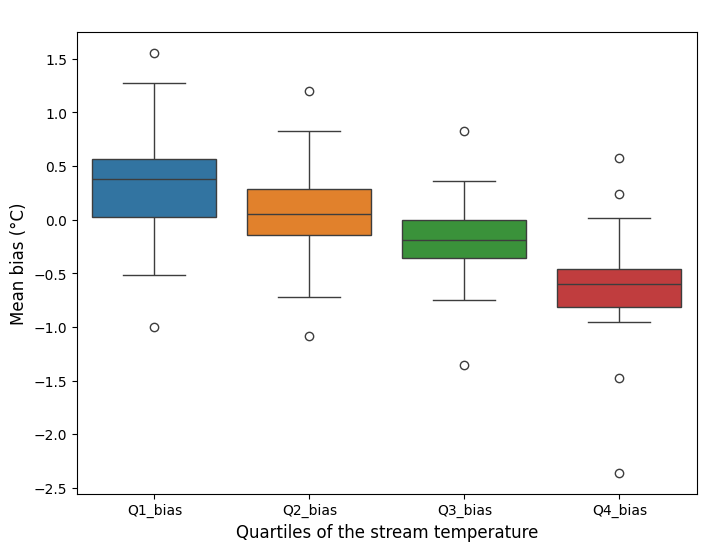

In [18]:
bias_q= bias_q[~ (bias_q['Q1_bias']==0) ]
print(bias_q)
# Create a boxplot of the four bias columns
plt.figure(figsize=(8, 6))
sns.boxplot(data=bias_q[['Q1_bias', 'Q2_bias', 'Q3_bias', 'Q4_bias']])
fontsize = 12
# Add labels and title
plt.title(' ')
plt.xlabel('Quartiles of the stream temperature' , fontsize = fontsize )
plt.ylabel('Mean bias (°C)', fontsize = fontsize)

plt.savefig('bias_q.png')


plt.show()

In [19]:
df1 = bias_q[["site", "Q1_obs", "Q1_bias"]].copy()
df2 = bias_q[["site", "Q2_obs", "Q2_bias"]].copy()
df3 = bias_q[["site", "Q3_obs", "Q3_bias"]].copy()
df4 = bias_q[["site", "Q4_obs", "Q4_bias"]].copy()

df1.columns = ["site", "obs", "bias"]
df2.columns = ["site", "obs", "bias"]
df3.columns = ["site", "obs", "bias"]
df4.columns = ["site", "obs", "bias"]

df_combined = pd.concat([df1, df2,df3,df4], ignore_index=True)



print(df_combined)


        site        obs      bias
0   12305000  11.990909  1.085118
1   12322000  12.900000  1.558663
2   13092747  15.738889  0.607556
3   13150430  15.253061  0.532000
4   13154500  17.683333  0.504204
..       ...        ...       ...
87  13317660  23.055814 -0.485343
88  13340000  24.540566 -0.630177
89  13340600  20.486916 -0.598650
90  13341050  13.739000 -0.814998
91  13342500  14.715652 -0.730430

[92 rows x 3 columns]


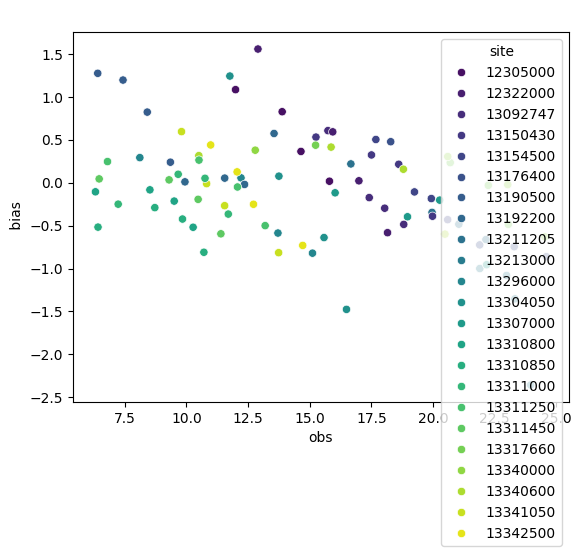

In [20]:


#plt.scatter(df_combined["obs"], df_combined["bias"], hue=df_combined["site"], palette="viridis")

sns.scatterplot(data=df_combined, x="obs", y="bias", hue="site", palette="viridis")

plt.xlabel("obs")
plt.ylabel(" bias")
plt.title(" ")


plt.show()

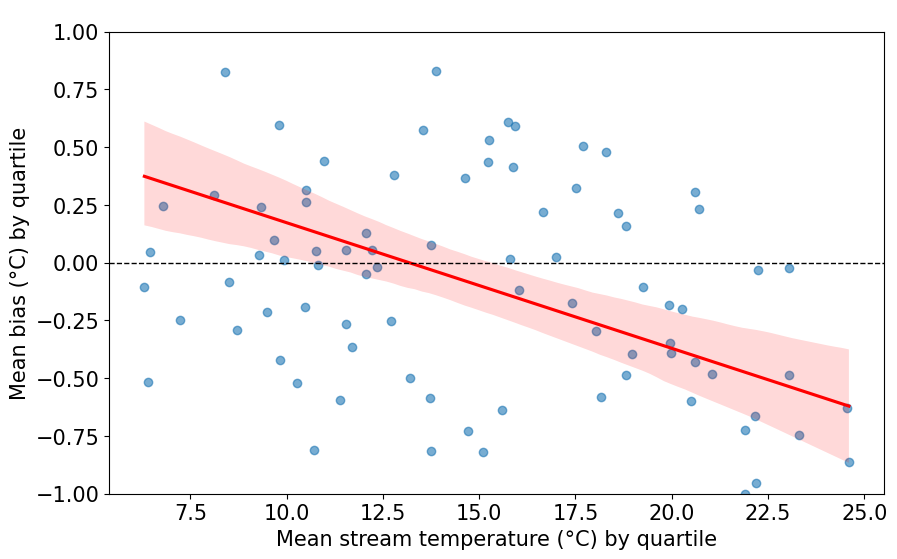

In [21]:

fontsize =15

#sns.set_style("whitegrid")

# Create scatter plot with trend line
plt.figure(figsize=(10, 6))
sns.regplot(data=df_combined, x="obs", y="bias", scatter_kws={"alpha": 0.6}, line_kws={"color": "red"})


# Add horizontal line at y=0
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)

# Set y-axis limits
plt.ylim(-1, 1)


plt.xlabel("Observed Values (obs)")
plt.ylabel("Bias")

plt.xticks( fontsize = fontsize )
plt.yticks( fontsize = fontsize )

plt.xlabel('Mean stream temperature (°C) by quartile' , fontsize = fontsize )
plt.ylabel('Mean bias (°C) by quartile', fontsize = fontsize)

plt.title(" ")

plt.savefig('bias_q_trend.png')

plt.show()


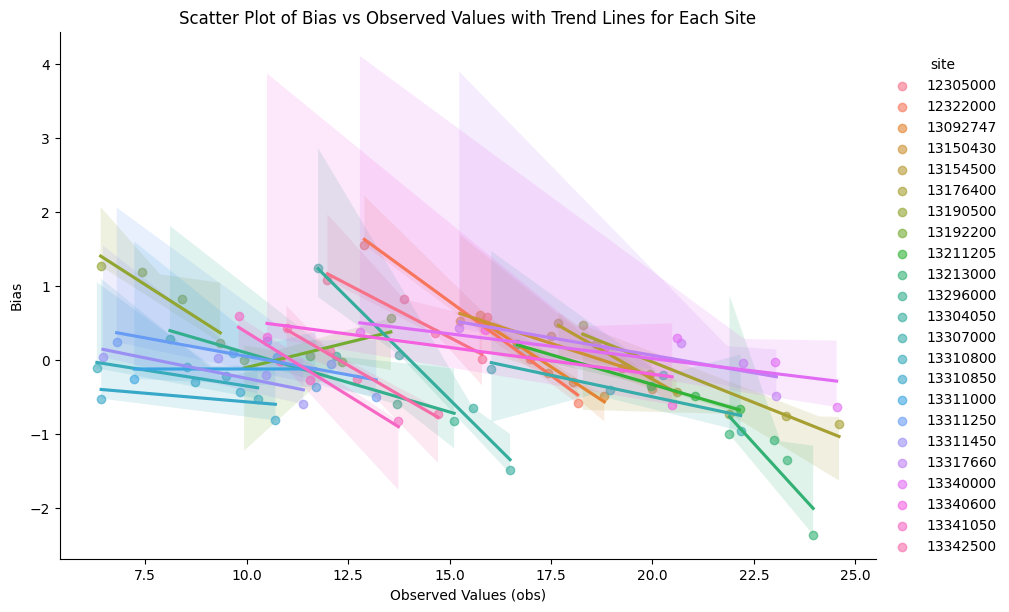

In [22]:
sns.lmplot(data=df_combined, x="obs", y="bias", hue="site", aspect=1.5, height=6, scatter_kws={"alpha": 0.6})

# Labels and title
plt.xlabel("Observed Values (obs)")
plt.ylabel("Bias")
plt.title("Scatter Plot of Bias vs Observed Values with Trend Lines for Each Site")

# Show plot
plt.show()


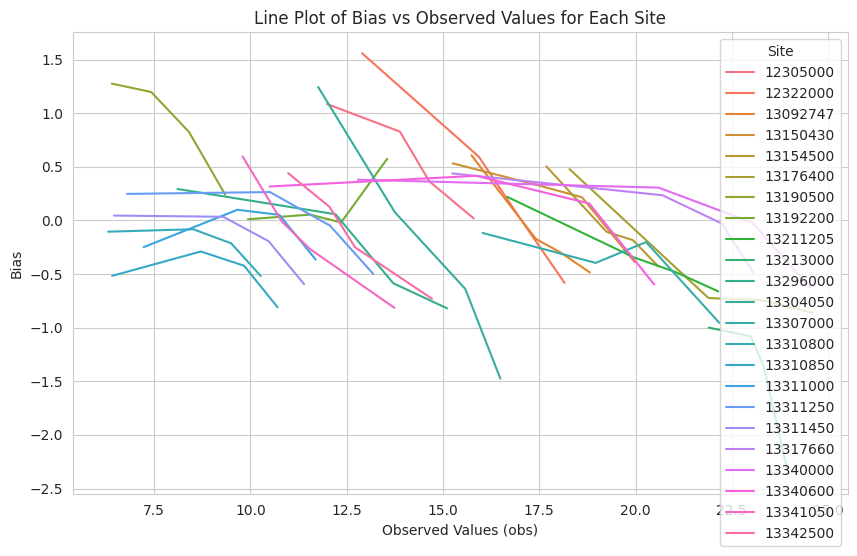

In [23]:
#import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set_style("whitegrid")

# Create line plot for each site
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_combined, x="obs", y="bias", hue="site"
            # , marker="o"
            )

# Labels and title
plt.xlabel("Observed Values (obs)")
plt.ylabel("Bias")
plt.title("Line Plot of Bias vs Observed Values for Each Site")

# Show legend and plot
plt.legend(title="Site")
plt.show()


9. RM SITE = 0 IN THE DF

In [24]:
var=var[var['range']>0 ]

10. merge filtered_df (USGS site info and data) AND evaluate_df

In [25]:
model_df_site = pd.merge(   filtered_df ,  evaluate_df ,left_on = "site_no" , right_on= "site" , how = "inner")

#print( model_df_site.columns )

model_df_site = model_df_site[[ 'site_no', 'dec_lat_va', 'dec_long_va', 'drain_area_va',
        'alt_va',    'number_of_obs'
                               , "grid_r2",  "grid_mse","grid_bias" , "grid_rmse", "grid_NSE","grid_std_ratio","grid_correlation","grid_KGE"
                               #, 'RMS', 'MSE','NSE',
       #'correlation_coefficient', 'mdi_importances_index_0',
      # 'mdi_importances_0', 'mdi_importances_index_1', 'mdi_importances_1'
                              # ,"permutation_0","permutation_importance_0","permutation_1","permutation_importance_1"
                              ]]

print( model_df_site )


     site_no  dec_lat_va  dec_long_va  drain_area_va   alt_va  number_of_obs  \
0   12305000   48.616883  -116.049194        11740.0  1794.75           1090   
1   12322000   48.996389  -116.507500        13700.0  1700.00            953   
2   13092747   42.562500  -114.494722          259.0  3630.00           1377   
3   13150430   43.323361  -114.108350           70.0  4834.45           1919   
4   13154500   43.002222  -115.202500        35800.0  2495.13           2088   
5   13176400   42.261369  -116.868442         2140.0  4253.65           1075   
6   13190500   43.343611  -115.477500          978.0  3833.07            460   
7   13192200   43.550556  -115.721944         1172.0      NaN            820   
8   13211205   43.677353  -116.701131         3363.0  2337.11            753   
9   13213000   43.781667  -116.972778         3906.0  2199.46            168   
10  13296000   44.278889  -114.733889          189.0  5950.00            995   
11  13304050   44.688792  -113.370406   

11. Sort the merged DataFrame model_df_site by 'grid_rmse'  

In [26]:



# Sort the DataFrame by 'grid_rmse' in ascending order
sorted_df = model_df_site[['site_no', 'number_of_obs', 'grid_r2', 'grid_mse','grid_bias', 'grid_rmse', 'grid_NSE',"grid_std_ratio","grid_correlation","grid_KGE" ]].sort_values(by='grid_rmse')

print(sorted_df)

#print(sorted_df.columns)

sorted_df.columns = ['site_no', 'number_of_obs', 'r2', 'MSE', 'BIAS',       'RMSE', 'NSE',"grid_std_ratio","grid_correlation","KGE"]

# Display the sorted DataFrame
print(sorted_df)

# Calculate mean and median for each column
mean_values = sorted_df[[ 'number_of_obs', 'r2', 'MSE', 'BIAS',       'RMSE', 'NSE','KGE']].mean().transpose()
median_values = sorted_df[[ 'number_of_obs', 'r2', 'MSE', 'BIAS',       'RMSE', 'NSE','KGE']].median().transpose()

print( mean_values.to_frame().transpose())
# Display the results
print("Mean for each column:\n", mean_values)
print( "mean_values", type(mean_values) )
print("\nMedian for each column:\n", median_values)

     site_no  number_of_obs   grid_r2  grid_mse  grid_bias  grid_rmse  \
13  13310800           1103  0.874394  0.315464  -0.217739   0.561662   
7   13192200            820  0.832725  0.326945   0.144117   0.571791   
17  13311450           1098  0.908933  0.357845  -0.174490   0.598202   
15  13311000           1101  0.883396  0.386968  -0.117419   0.622068   
4   13154500           2088  0.693833  0.410202  -0.041550   0.640470   
2   13092747           1377  0.683433  0.484580  -0.071572   0.696118   
8   13211205            753  0.894385  0.529429  -0.309338   0.727619   
16  13311250           1012  0.918442  0.537925  -0.007768   0.733434   
18  13317660           1748  0.942348  0.596277   0.045260   0.772190   
14  13310850           1042  0.761576  0.712444  -0.500005   0.844064   
10  13296000            995  0.903190  0.760408  -0.256101   0.872014   
3   13150430           1919  0.770767  0.804744   0.175230   0.897075   
12  13307000            786  0.845694  0.917044  -0

12. merge sorted_df and var (variability)

In [27]:
#print(sorted_df)
#print(var)
#print(var[~var['site'].isin(sorted_df['site_no']) ])
sorted_df_var=pd.merge(sorted_df,var,left_on="site_no",right_on="site")
print("sorted_df_var:",sorted_df_var)

# Calculate the median of each column
medians = sorted_df_var[['number_of_obs','r2','RMSE','KGE']].median()
print("\nMedian of each column:")
print(medians)




sorted_df_var:      site_no  number_of_obs        r2       MSE      BIAS      RMSE       NSE  \
0   13310800           1103  0.874394  0.315464 -0.217739  0.561662  0.874394   
1   13192200            820  0.832725  0.326945  0.144117  0.571791  0.832725   
2   13311450           1098  0.908933  0.357845 -0.174490  0.598202  0.908933   
3   13311000           1101  0.883396  0.386968 -0.117419  0.622068  0.883396   
4   13154500           2088  0.693833  0.410202 -0.041550  0.640470  0.693833   
5   13092747           1377  0.683433  0.484580 -0.071572  0.696118  0.683433   
6   13211205            753  0.894385  0.529429 -0.309338  0.727619  0.894385   
7   13311250           1012  0.918442  0.537925 -0.007768  0.733434  0.918442   
8   13317660           1748  0.942348  0.596277  0.045260  0.772190  0.942348   
9   13310850           1042  0.761576  0.712444 -0.500005  0.844064  0.761576   
10  13296000            995  0.903190  0.760408 -0.256101  0.872014  0.903190   
11  13150430 

13. Interannual variability of discharge shown as coefficient of variation (CV)

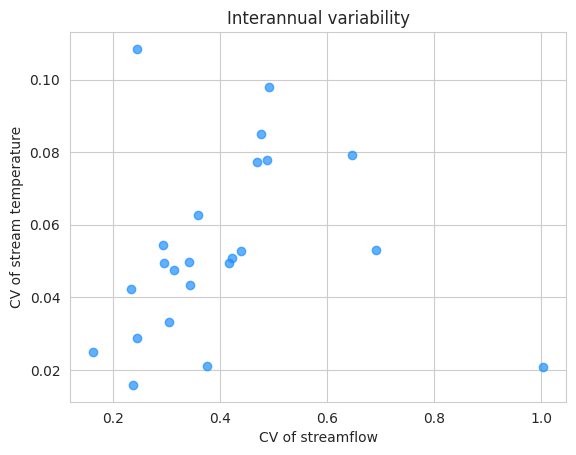

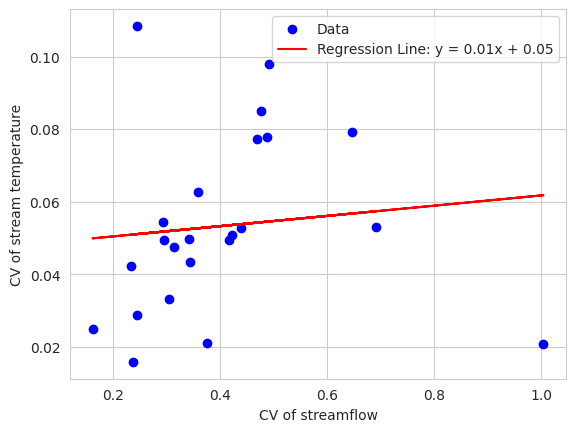

In [28]:
plt.scatter(  sorted_df_var['inter_cv_q'],sorted_df_var['inter_cv_st'], color='dodgerblue', alpha=0.7)
plt.xlabel('CV of streamflow')
plt.ylabel('CV of stream temperature')
plt.title('Interannual variability')
plt.grid(True)
plt.savefig("Interannual_variability.png"
            #, dpi=300
           # , bbox_inches="tight"
           )  # Save with high resolution
plt.show()

y = sorted_df_var['inter_cv_st']
x = sorted_df_var['inter_cv_q']

# Fit a linear regression model (y = mx + b)
slope, intercept = np.polyfit(x, y, 1)

# Generate predicted y values based on the regression line
y_pred = slope * x + intercept

# Create the scatter plot
plt.scatter(x, y, label="Data", color="blue")

# Plot the regression line
plt.plot(x, y_pred, color="red", label=f"Regression Line: y = {slope:.2f}x + {intercept:.2f}")

# Add labels and legend
plt.ylabel('CV of stream temperature')
plt.xlabel('CV of streamflow')
plt.legend()

# Show the plot
plt.show()

In [29]:
y = sorted_df_var['inter_cv_st']
x = sorted_df_var['inter_cv_q']

#import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Example data (replace with your actual data)
x = np.array( x).reshape(-1, 1)  # Independent variable
y = np.array( y)  # Dependent variable

# Create a linear regression model
model = LinearRegression()

# Fit the model to the data
model.fit(x, y)

# Predictions
y_pred = model.predict(x)

# Model accuracy (R-squared)
r2 = r2_score(y, y_pred)
mse = mean_squared_error(y, y_pred)

# Print the results
print(f"Slope: {model.coef_[0]}")
print(f"Intercept: {model.intercept_}")
print(f"R-squared: {r2:.4f}")
print(f"Mean Squared Error: {mse:.4f}")


Slope: 0.014101239592918244
Intercept: 0.047631815483491366
R-squared: 0.0110
Mean Squared Error: 0.0006


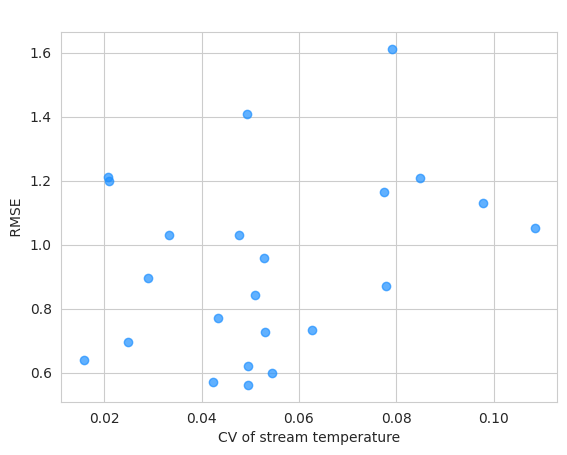

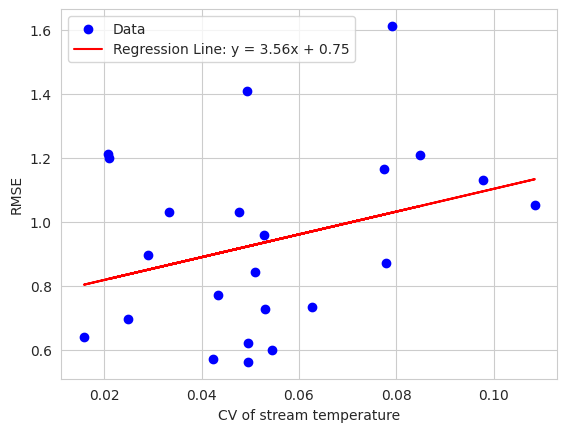

In [30]:
plt.scatter(  sorted_df_var['inter_cv_st'],sorted_df_var['RMSE'], color='dodgerblue', alpha=0.7)
plt.ylabel(' RMSE ')
plt.xlabel('CV of stream temperature')
plt.title(' ')
plt.grid(True)
plt.savefig("cv_st_RMSE.png"
            #, dpi=300
           # , bbox_inches="tight"
           )  # Save with high resolution
plt.show()

x = sorted_df_var['inter_cv_st']
y = sorted_df_var['RMSE']
#print(x)
#print(y)

# Fit a linear regression model (y = mx + b)
slope, intercept = np.polyfit(x, y, 1)

# Generate predicted y values based on the regression line
y_pred = slope * x + intercept




# Create the scatter plot
plt.scatter(x, y, label="Data", color="blue")

# Plot the regression line
plt.plot(x, y_pred, color="red", label=f"Regression Line: y = {slope:.2f}x + {intercept:.2f}")

# Add labels and legend
plt.xlabel('CV of stream temperature')
plt.ylabel('RMSE')
plt.legend()

# Show the plot
plt.show()

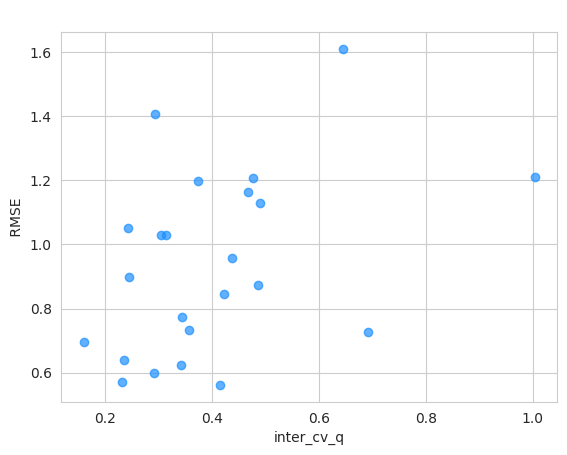

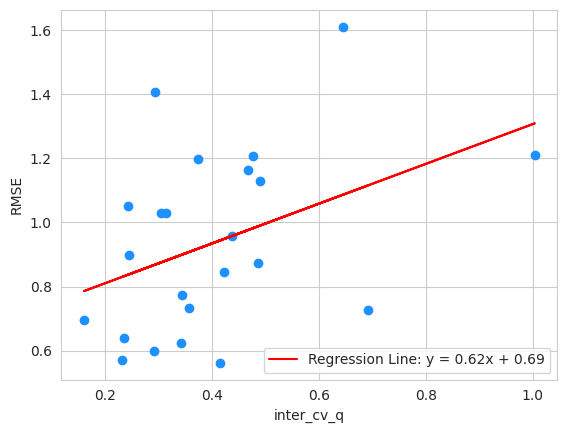

In [31]:
plt.scatter(  sorted_df_var['inter_cv_q'],sorted_df_var['RMSE'], color='dodgerblue', alpha=0.7)
plt.ylabel(' RMSE ')
plt.xlabel('inter_cv_q')
plt.title(' ')
plt.grid(True)
#plt.savefig("std_dev_st_RMSE.png"
            #, dpi=300
           # , bbox_inches="tight")  # Save with high resolution
plt.show()

# Assuming sorted_df_var is already defined
x = sorted_df_var['inter_cv_q']
y = sorted_df_var['RMSE']

# Fit a linear regression model (y = mx + b)
slope, intercept = np.polyfit(x, y, 1)

# Generate predicted y values based on the regression line
y_pred = slope * x + intercept

# Create the scatter plot
plt.scatter(x, y
            #, label="Data"
            , color="dodgerblue")

# Plot the regression line
plt.plot(x, y_pred, color="red", label=f"Regression Line: y = {slope:.2f}x + {intercept:.2f}")

# Add labels and legend
plt.xlabel('inter_cv_q')
plt.ylabel('RMSE')
plt.legend()

# Show the plot
plt.show()

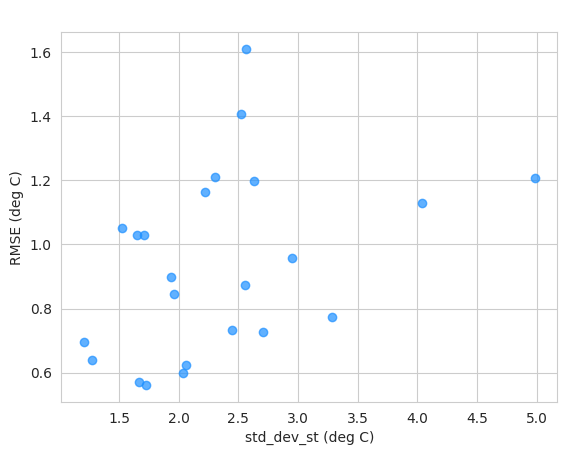

In [32]:


plt.scatter(  sorted_df_var['std_dev_st'],sorted_df_var['RMSE'], color='dodgerblue', alpha=0.7)
plt.ylabel('RMSE (deg C)')
plt.xlabel('std_dev_st (deg C)')
plt.title(' ')
plt.grid(True)
plt.savefig("std_dev_st_RMSE.png"
            #, dpi=300
           # , bbox_inches="tight"
           )  # Save with high resolution
plt.show()

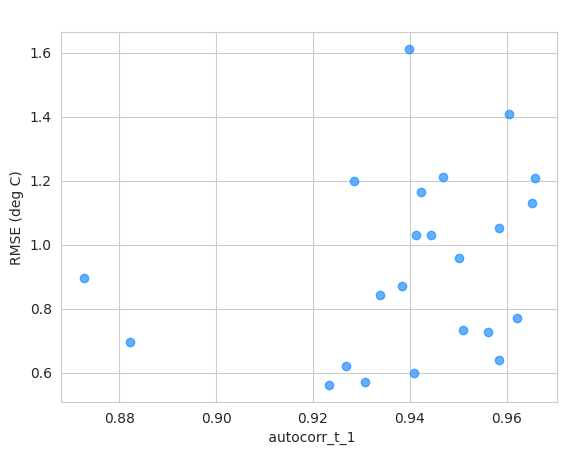

In [33]:



plt.scatter(  sorted_df_var['autocorr_t_1'],sorted_df_var['RMSE'], color='dodgerblue', alpha=0.7)
plt.ylabel('RMSE (deg C)')
plt.xlabel(' autocorr_t_1')
plt.title(' ')
plt.grid(True)
#plt.savefig("std_dev_st_RMSE.png"
            #, dpi=300
           # , bbox_inches="tight"           )  # Save with high resolution
plt.show()


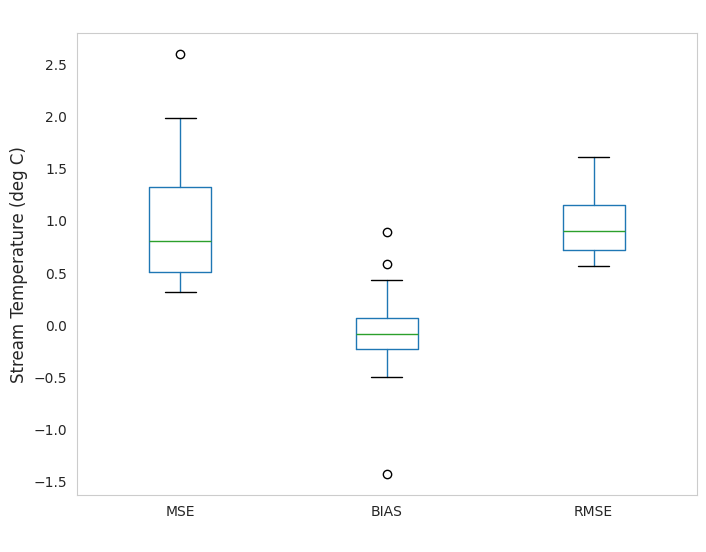

In [34]:
# Plot boxplots for each column
plt.figure(figsize=(8, 6))
sorted_df.boxplot(column=[ 'MSE', 'BIAS','RMSE' ], grid=False)

# Customize plot
plt.title(" ", fontsize=14)
plt.ylabel("Stream Temperature (deg C)", fontsize=12)
plt.xlabel(" ", fontsize=12)
#plt.show()

# Save the plot locally
plt.savefig("box.png"
            #, dpi=300
           # , bbox_inches="tight"
           )  # Save with high resolution
plt.show()

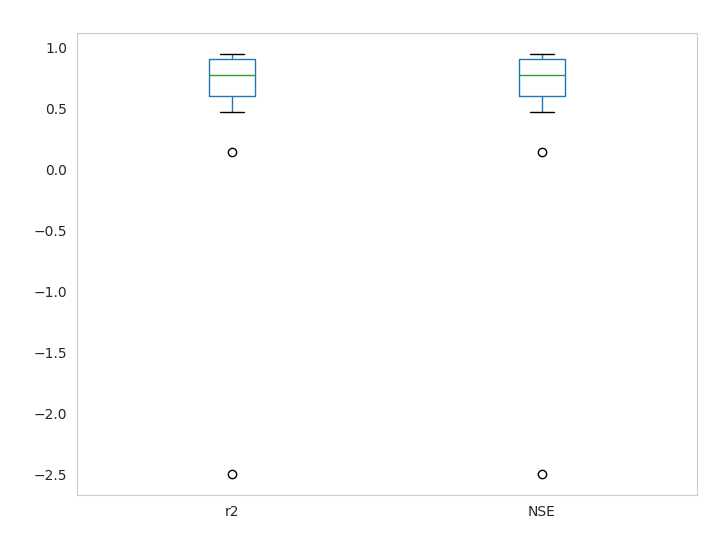

In [35]:
plt.figure(figsize=(8, 6))
sorted_df.boxplot(column=[ 'r2','NSE' ], grid=False)


plt.title(" ", fontsize=14)
plt.ylabel(" ", fontsize=12)
plt.xlabel(" ", fontsize=12)


plt.show()

Index(['site', 'std_dev_st', 'cv_q', 'inter_cv_q', 'inter_cv_st', 'range',
       'autocorr_t_1', 'autocorr_t_2'],
      dtype='object')


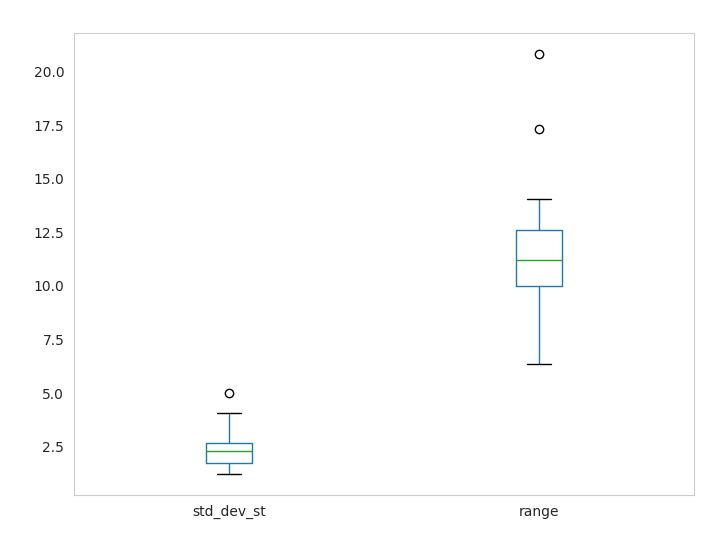

In [36]:
print(var.columns)
plt.figure(figsize=(8, 6))
var.boxplot(column=[  'std_dev_st', 'range'  ], grid=False)


plt.title(" ", fontsize=14)
plt.ylabel(" ", fontsize=12)
plt.xlabel(" ", fontsize=12)


plt.show()

Index(['site', 'std_dev_st', 'cv_q', 'inter_cv_q', 'inter_cv_st', 'range',
       'autocorr_t_1', 'autocorr_t_2'],
      dtype='object')


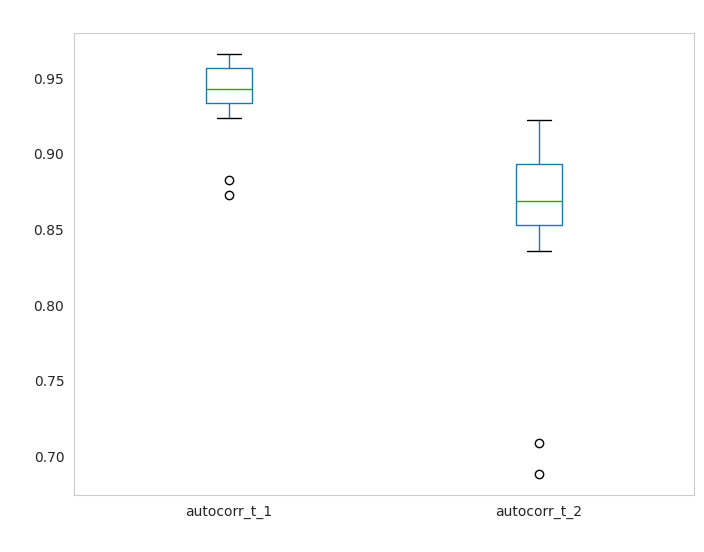

In [37]:
print(var.columns)
plt.figure(figsize=(8, 6))
var.boxplot(column=[    'autocorr_t_1' , 'autocorr_t_2'
                   # , 'autocorr_t_3'
                   ], grid=False)


plt.title(" ", fontsize=14)
plt.ylabel(" ", fontsize=12)
plt.xlabel(" ", fontsize=12)


plt.show()

save to csv

In [38]:
df_cleaned.to_csv( df_cleaned_csv )
model_df_site.to_csv( model_df_site_csv )
sorted_df[['site_no', 'number_of_obs',   'MSE', 'BIAS',       'RMSE', 'NSE',"KGE","grid_std_ratio","grid_correlation"]].to_csv( sorted_df_csv )
sorted_df_var[['site_no', 'number_of_obs',   'MSE', 'BIAS',       'RMSE', 'NSE',"KGE", "std_dev_st", "cv_q","inter_cv_q","inter_cv_st", "range",  "autocorr_t_1" ,"grid_std_ratio","grid_correlation"  ]].to_csv( sorted_df_var_csv )

In [39]:
df_site_pred_test_0

site_pred_test = df_site_pred_test_0[ df_site_pred_test_0['y_test']>0 ]

print(site_pred_test)

site_pred_test.to_csv(  site_pred_test_csv )


          site  y_test  y_pred_best
1829  13342500    10.9     10.44350
1830  13342500    11.5     10.60275
1831  13342500    11.5     11.06375
1832  13342500    11.5     10.71625
1833  13342500    10.2     10.62275
...        ...     ...          ...
1085  12305000    13.7     13.60250
1086  12305000    12.5     13.35500
1087  12305000    12.9     13.81700
1088  12305000    13.9     13.96250
1089  12305000    14.8     14.35400

[5716 rows x 3 columns]


3.9805
26.6
26.000749999999986
26.6


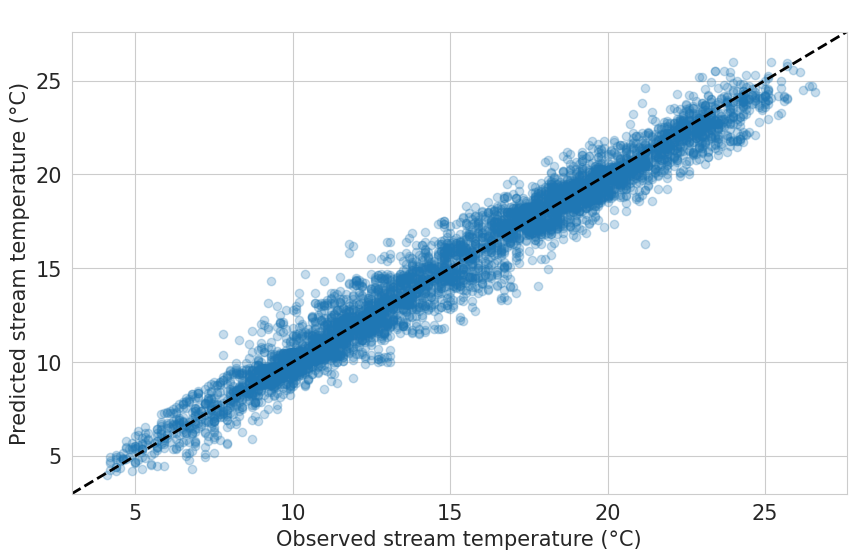

In [40]:
fontsize =15

min_1= site_pred_test[ 'y_test'].min( )
min_2= site_pred_test['y_pred_best'].min( )
min=np.min([min_1,min_2] )
print(min)

max_1= site_pred_test[ 'y_test'].max( )
print(max_1)
max_2= site_pred_test['y_pred_best'].max( )
print(max_2)
max=np.max([ max_1, max_2] )
print(max)

plt.figure(figsize=(10, 6))
plt.scatter( site_pred_test['y_test'],  site_pred_test['y_pred_best'], alpha=0.25)
plt.plot([ min -1 , max +1 ], [min -1 , max + 1 ], 'k--', lw=2)

plt.ylim( min -1 , max +1)
plt.xlim( min -1 , max +1)

plt.xticks( fontsize = fontsize )
plt.yticks( fontsize = fontsize )

plt.xlabel('Observed stream temperature (°C)' , fontsize = fontsize )
plt.ylabel('Predicted stream temperature (°C)' , fontsize = fontsize )
plt.title(' ')


plt.savefig('test_pred.png')


plt.show()